# Imports

In [1]:
# System
import sys
import os
import math
# Time
import time
# Date time
import datetime as dt
# PyTorch framework
import torch
from torch import nn
# Work with arrays
import numpy as np
# Work with dataframes
import pandas as pd
# Make figures
import matplotlib.pyplot as plt
import seaborn as sns
# Hyperparameters optimization
import optuna

# Amplitude functions

## Gaussian

In [2]:
class Gaussian(nn.Module):
  """Custom Gaussian amplitude function class"""

  def __init__(self, config, bandwidth=1.0):
    super().__init__()
    self.coordinateSpaceDim = config['coordinate space dimension']
    self.numberOfStates = config['number of states']
    self.device = config['device']

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    forward = torch.ones(
      (
        len(x),
        self.numberOfStates
      ),
      device=self.device
    )
    forward = torch.mul(
      forward.t(),
      torch.exp(-torch.sum(x**2, axis=1) / 2)
    ).t()
    return forward

  def gradient(self, x: torch.Tensor) -> torch.Tensor:
    gradient = torch.ones(
      (
        len(x),
        self.coordinateSpaceDim,
        self.numberOfStates
      ),
      device=self.device
    )
    for coordinateNumber in range(self.coordinateSpaceDim):
      temporalTerm = torch.ones(
        (
          len(x),
          self.numberOfStates
        ),
        device=self.device
      )
      temporalTerm = torch.mul(
        temporalTerm.t(),
        torch.exp(-torch.sum(x**2, axis=1) / 2) * (-2 * x[:, coordinateNumber] / 2),
      ).t()
      gradient[:, coordinateNumber, :] = temporalTerm
    return gradient

  def laplacian(self, x: torch.Tensor) -> torch.Tensor:
    laplacian = torch.ones(
      (
        len(x),
        self.numberOfStates
      ),
      device=self.device
    )
    laplacian = torch.mul(
      laplacian.t(),
      torch.exp(-torch.sum(x**2, axis=1) / 2)
      * (
        torch.sum((-2 * x / 2) ** 2, axis=1)
        - 2 * torch.sum(torch.ones_like(x) / 2, axis=1)
      )
    ).t()
    return laplacian


# Neural network

In [3]:
class NeuralNetwork(nn.Module):
  """Class for a neural network"""

  def __init__(self, config):
    super().__init__()
    self.coordinateSpaceDim = config['coordinate space dimension']
    self.numberOfStates = config['number of states']
    self.hiddenLayerSize = config['hidden layer size']
    self.device = config['device']
    self.defActivationFunction(config)
    self.numberOfHiddenLayers = config['number of hidden layers']
    self.defAndInitStack(config['std of initial weights'])
    self.stack.to(self.device)

  def defActivationFunction(self, config):
    if config['activation function'] == 'sin':
      self.activationFunction = CustomSin()
    elif config['activation function'] == 'tanh':
      self.activationFunction = CustomTanh()
    else:
      print("INVALID ACTIVATION FUNCTION NAME")
      sys.exit(1)

  def defAndInitStack(self, stdOfInitWeights):
    self.stack = nn.Sequential()
    self.stack.append(
      nn.Linear(
        self.coordinateSpaceDim,
        self.hiddenLayerSize
      )
    )
    self.stack.append(
      self.activationFunction
    )
    for hiddenLayerNumber in range(self.numberOfHiddenLayers-1):
      self.stack.append(
        nn.Linear(
          self.hiddenLayerSize,
          self.hiddenLayerSize
        )
      )
      self.stack.append(
        self.activationFunction
      )
    self.stack.append(
      nn.Linear(
        self.hiddenLayerSize,
        self.numberOfStates
      )
    )
    self.stack.append(
      self.activationFunction
    )
    for stackSliceNumber in range(len(self.stack)):
      if "weight" in dir(self.stack[stackSliceNumber]):
        nn.init.normal_(
          self.stack[stackSliceNumber].weight,
          0,
          stdOfInitWeights
        )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.stack(x)

  def gradient(self, x: torch.Tensor) -> torch.Tensor:
    gradient = (
      torch.zeros(
        (
          len(x),
          self.coordinateSpaceDim,
          self.numberOfStates
        ),
        device = self.device
      )
    )
    for coordinateNumber in range(self.coordinateSpaceDim):
      firstDerivative = self.activationFunction.firstDerivative(
        self.stack[0](x)
      ) * self.stack[0].weight[:, coordinateNumber]
      function = self.stack[0*2+1](self.stack[0*2](x))
      for hiddenLayerNumber in range(1, self.numberOfHiddenLayers + 1):
        firstDerivative = self.activationFunction.firstDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
          firstDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        )
        function = self.stack[hiddenLayerNumber * 2 + 1](
          self.stack[hiddenLayerNumber * 2](function)
        )
      gradient[:, coordinateNumber, :] = firstDerivative
    return gradient

  def laplacian(self, x: torch.Tensor) -> torch.Tensor:
    preresult = torch.ones(
      (
        len(x),
        self.coordinateSpaceDim,
        self.numberOfStates
      ),
      device=self.device
    )
    for coordinateNumber in range(self.coordinateSpaceDim):
      firstDerivative = self.activationFunction.firstDerivative(
        self.stack[0](x)
      ) * self.stack[0].weight[:, coordinateNumber]
      secondDerivative = self.activationFunction.secondDerivative(
        self.stack[0](x)
      ) * self.stack[0].weight[:, coordinateNumber] ** 2
      function = self.stack[0 * 2 + 1](self.stack[0 * 2](x))
      for hiddenLayerNumber in range(1, self.numberOfHiddenLayers + 1):
        secondDerivative = self.activationFunction.secondDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
          firstDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        ) ** 2 \
        + self.activationFunction.firstDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
            secondDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        )
        firstDerivative = self.activationFunction.firstDerivative(
          self.stack[hiddenLayerNumber * 2](function)
        ) * torch.matmul(
          firstDerivative, self.stack[hiddenLayerNumber * 2].weight.t()
        )
        function = self.stack[hiddenLayerNumber * 2 + 1](
          self.stack[hiddenLayerNumber * 2](function)
        )
      preresult[:, coordinateNumber, :] = secondDerivative
    return torch.sum(preresult, axis=1)

class CustomSin(nn.Module):
    """Custom sin activation function class"""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(x)

    def firstDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return torch.cos(x)

    def secondDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return -torch.sin(x)

class CustomTanh(nn.Module):
    """Custom tanh activation function class"""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.tanh(x)

    def firstDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return 1 / torch.cosh(x) ** 2

    def secondDerivative(self, x: torch.Tensor) -> torch.Tensor:
        return -2 * torch.sinh(x) / torch.cosh(x) ** 3

# Distribution density

In [4]:
def distributionDensity(x: torch.Tensor) -> torch.Tensor:
    bandwidth = 0.2
    res = torch.sum(
        torch.exp(-torch.cdist(x, x, p=2)**2 / 2 / bandwidth**2),
        axis=1
    )
    return (res / res.sum())

# Trial function

In [49]:
class TrialFunction(nn.Module):
  """Trial function class"""

  def __init__(self, config, name: str):
    """Initialize trial function"""
    super().__init__()
    self.name = name
    self.PATH = "../models/" + self.name + ".pt"
    self.defDevice(config)
    self.neuralNetwork = NeuralNetwork(config)
    self.defAmplitudeFunction(config)
    print("Trial function with name "+name+" has been created")

  def defDevice(self, config):
    """Define device"""
    self.device = config['device']

  def defAmplitudeFunction(self, config):
    """Define amplitude function"""
    if config['amplitude function'] == 'gaussian':
      self.amplitudeFunction = Gaussian(config)
    else:
      print("INVALID AMPLITUDE FUNCTION NAME")
      sys.exit(1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    forward = self.neuralNetwork(x) * self.amplitudeFunction(x)
    return forward

  def gradient(self, x: torch.Tensor) -> torch.Tensor:
    gradient = (
      torch.zeros(
        (
          len(x),
          self.neuralNetwork.coordinateSpaceDim,
          self.neuralNetwork.numberOfStates
        ),
        device = self.device
      )
    )
    theAmplitudeFunction = self.amplitudeFunction(x)
    theAmplitudeFunctionGradient = self.amplitudeFunction.gradient(x)
    theNeuralNetwork = self.neuralNetwork(x)
    theNeuralNetworkGradient = self.neuralNetwork.gradient(x)
    for coordinateNumber in range(self.neuralNetwork.coordinateSpaceDim):
      gradient[:, coordinateNumber, :] = (
        theNeuralNetworkGradient[:, coordinateNumber, :] * theAmplitudeFunction
        + theNeuralNetwork * theAmplitudeFunctionGradient[:, coordinateNumber, :]
      )
    return gradient

  def laplacian(self, x: torch.Tensor) -> torch.Tensor:
    laplacian = (
      self.neuralNetwork.laplacian(x) * self.amplitudeFunction(x)
      + self.neuralNetwork(x) * self.amplitudeFunction.laplacian(x)
      + 2 * torch.sum(
        self.neuralNetwork.gradient(x) * self.amplitudeFunction.gradient(x),
        axis=1
      )
    )
    return laplacian

  def weightFunction(self, x: torch.Tensor) -> torch.Tensor:
    weightFunction = torch.mean(self.forward(x)**2, axis=1)
    return weightFunction

  def norm(self, x: torch.Tensor, isTrainSample=True) -> torch.Tensor:
    norm = torch.zeros(
      self.neuralNetwork.numberOfStates,
      device=self.device
    )
    forward = self.forward(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    for stateNumber in range(self.neuralNetwork.numberOfStates):
      norm[stateNumber] = torch.mean(
        forward[:, stateNumber]**2 / weightFunction
      )
    return norm

  def spectrum(self, x: torch.Tensor, isTrainSample=True) -> torch.Tensor:
    spectrum = torch.zeros(
      self.neuralNetwork.numberOfStates,
      device=self.device
    )
    forward = self.forward(x)
    laplacian = self.laplacian(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    potential = 0.5 * torch.sum(x*x, axis=1)
    for stateNumber in range(self.neuralNetwork.numberOfStates):
      spectrum[stateNumber] = torch.mean(
        forward[:, stateNumber] * (
          -0.5* laplacian[:, stateNumber]
          + potential * forward[:, stateNumber]
        ) / weightFunction
      )
    spectrum = spectrum / self.norm(x, isTrainSample)
    return spectrum

  def totalSqueredResidual(self, x: torch.Tensor, isTrainSample=True) -> torch.Tensor:
    forward = self.forward(x)
    laplacian = self.laplacian(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    spectrum = self.spectrum(x, isTrainSample)
    norm = self.norm(x, isTrainSample)
    return sum(
      [
        torch.mean(
          (
            -0.5 * laplacian[:, stateNumber]
            + 0.5 * forward[:, stateNumber] * torch.sum(x**2, axis=1)
            - forward[:, stateNumber] * spectrum[stateNumber]
          )** 2 / weightFunction
        ) / norm[stateNumber]
        for stateNumber in range(self.neuralNetwork.numberOfStates)
      ]
    )

  def squeredResidual(
      self, 
      x: torch.Tensor, 
      isTrainSample=True
  ) -> torch.Tensor:
    forward = self.forward(x)
    laplacian = self.laplacian(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    spectrum = self.spectrum(x, isTrainSample)
    norm = self.norm(x, isTrainSample)
    return [
        torch.mean(
          (
            -0.5 * laplacian[:, stateNumber]
            + 0.5 * forward[:, stateNumber] * torch.sum(x**2, axis=1)
            - forward[:, stateNumber] * spectrum[stateNumber]
          )** 2 / weightFunction
        ) / norm[stateNumber]
        for stateNumber in range(self.neuralNetwork.numberOfStates)
      ]

  def totalNormalisationError(
      self, 
      x: torch.Tensor, 
      isTrainSample=True
  ) -> torch.Tensor:
    return torch.sum((self.norm(x, isTrainSample) - torch.tensor(1, device=self.device)) ** 2)

  def totalOrthogonalisationError(
      self, 
      x: torch.Tensor, 
      isTrainSample=True
  ) -> torch.Tensor:
    orthogonError = torch.zeros(
      (
        self.neuralNetwork.numberOfStates,
        self.neuralNetwork.numberOfStates
      ),
      device=self.device
    )
    forward = self.forward(x)
    weightFunction = self.weightFunction(x) if isTrainSample else distributionDensity(x)
    norm = self.norm(x, isTrainSample)
    for stateNumber1 in range(1, self.neuralNetwork.numberOfStates):
      for stateNumber2 in range(0, stateNumber1):
        orthogonError[stateNumber1, stateNumber2] = (
          torch.square(
            torch.mean(
              forward[:, stateNumber1]
              * forward[:, stateNumber2]
              / weightFunction
            )
          )
          / norm[stateNumber1]
          / norm[stateNumber2]
        )
    return torch.sum(orthogonError)

# Metropolis sampler

In [11]:
class MetropolisSampler():
  """Class for Metropolis sampler"""

  def __init__(self, config):
    self.epsilon = config['metropolis algorithm parameter']
    self.device = config['device']
    self.sample = self.initialSample(config)

  def initialSample(self, config) -> torch.Tensor:
    return 3 * (
      torch.rand(
        (
          config['sample size'],
          config['coordinate space dimension']
        )
      ) - 0.5
    ).to(self.device)

  def updateSampleBasOnDistrDens(self, __distributionDensity):
    newSample = self.sample + self.epsilon * (
      2 * torch.rand_like(
        self.sample,
        device=self.device
      ) - 1
    )
    critVal = __distributionDensity(newSample) / __distributionDensity(self.sample)
    doesPointMove = (torch.rand(len(self.sample), device=self.device) <= critVal)
    newSample = (
      torch.mul(doesPointMove.int(), newSample.t()).t()
      + torch.mul((1 - doesPointMove.int()), self.sample.t()).t()
    )
    self.sample = newSample

# Train NN-based solver for one state

In [43]:
def createAndTrainForOneState(
    otherTrialFncs: list,
    otherValidStates: list,
    config,
    minResidual
):
    
    time0 = time.time()
    hist = {
        'time' : list(),
        'tot loss' : list(),
        'sqr res' : list(),
        'norm dev' : list(),
        'in orthog dev' : list(),
        'ex orthog dev' : list(),
    }
    for i in range(config['number of states']):
        hist[f"e{i}"] = list()
    
    name = str(
        f"{config['coordinate space dimension']}d_"
        +f"{config['hidden layer size']}L_"
        +f"{config['number of hidden layers']}Nh_"
        +time.strftime("%d%b%Y_%H:%M:%S", time.gmtime())
    )
    theTrialFncs = TrialFunction(config, name)

    optimizer = torch.optim.AdamW(
        params=list(theTrialFncs.parameters()),
        lr=config['initial learning rate'],
        weight_decay=config['weight decay'],
    )

    lossFnc = nn.L1Loss()
    
    sqrRes =  torch.tensor(1e20)
    step = 0
    while sqrRes.item() >= minResidual and step < config["number of training steps"]:
        if step == 0:
            sampler = MetropolisSampler(config)
        else:
            for i in range(10):
                sampler.updateSampleBasOnDistrDens(
                    theTrialFncs.weightFunction
                )
        step += 1
        # Loss
        sample = sampler.sample
        sqrRes = theTrialFncs.totalSqueredResidual(sample)
        normDev = theTrialFncs.totalNormalisationError(sample)
        e = theTrialFncs.spectrum(sample)
        inOrthogDev = theTrialFncs.totalOrthogonalisationError(sample)
        exOrthogDev = calcExOrthogDev(theTrialFncs, otherTrialFncs, otherValidStates, sample)
        eFactor = float(torch.sum(e).detach().item())
        totLoss = lossFnc(
            sqrRes + normDev + torch.sum(e) / eFactor + inOrthogDev + 40.0 * exOrthogDev,
            torch.tensor([0.0]).to(config['device'])
        )
        # Backpropagation
        optimizer.zero_grad()
        totLoss.backward()
        optimizer.step()
        # History
        hist['time'] += [time.time() - time0]
        hist['tot loss'] += [totLoss.item()]
        hist['sqr res'] += [sqrRes.item()]
        hist['norm dev'] += [normDev.item()]
        hist['in orthog dev'] += [inOrthogDev.item()]
        hist['ex orthog dev'] += [exOrthogDev.item()]
        for i in range(config['number of states']):
            hist[f"e{i}"] += [e[i].item()]
        if (step % 100) == 0:
            if step == 100:
                header = (
                    "step, time, tot loss, sqr res,"
                    + " norm dev, in orthog dev, ex orthog dev"
                )
                for i in range(config['number of states']):
                    header += f", e{i}"
                print(header)
            info = (
                f"{step}, "
                + f"{time.time() - time0:.2f}, "
                + f"{totLoss.item():.2e}, "
                + f"{sqrRes.item():.2e}, "
                + f"{normDev.item():.2e}, "
                + f"{inOrthogDev.item():.2e}, "
                + f"{exOrthogDev.item():.2e}"
            )
            for i in range(config['number of states']):
                info += f", {e[i]:.2e}"
            print(info)
    return theTrialFncs, hist, optimizer

In [44]:
def calcExOrthogDev(theTrialFncs, otherTrialFncs, otherValidStates, x):
    exOrthogDev = torch.tensor([0.0]).to(theTrialFncs.device)
    
    theForward = theTrialFncs.forward(x)
    otherForward = otherTrialFncs.forward(x)
    
    theWeightFunction = theTrialFncs.weightFunction(x)
    otherWeightFunction = otherTrialFncs.weightFunction(x)
    
    theNorm = theTrialFncs.norm(x)
    otherNorm = otherTrialFncs.norm(x)

    for i in range(theTrialFncs.neuralNetwork.numberOfStates):
        for j in otherValidStates:
            exOrthogDev += torch.square(
                torch.mean(
                    theForward[:, i] * otherForward[:, j]
                    / torch.sqrt(theWeightFunction)
                    / torch.sqrt(otherWeightFunction)
                )
                / theNorm[i] / otherNorm[j]
            )
    return exOrthogDev

In [45]:
name = "L20_Nh1_21Oct2023_23:33:11"

config = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : 20,
        "number of hidden layers" : 1,
        "coordinate space dimension" : 3,
        "number of states" : 5,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        "std of initial weights" : math.sqrt(0.1)
    }

otherTrlFncs = TrialFunction(
    config,
    "3d_"+name
)
otherTrlFncs.load_state_dict(torch.load(otherTrlFncs.PATH))
otherTrlFncs.eval()
for i in range(1):
    sampler = MetropolisSampler(config)
    e = otherTrlFncs.spectrum(sampler.sample)
    print(i, e.cpu().detach().numpy())
    print([otherTrlFncs.squeredResidual(sampler.sample, i).item() for i in range(config['number of states'])])

Trial function with name 3d_L20_Nh1_21Oct2023_23:33:11 has been created
0 [1.4977623 2.507683  3.5910776 2.5076377 2.5106952]
[0.00048599994624964893, 0.002258618827909231, 0.003708719043061137, 0.001752413809299469, 0.0010570634622126818]


In [46]:
otherValidStates = [0]

In [47]:
config = {
        "device" : "cuda" if torch.cuda.is_available() else "cpu",
        "activation function" : "sin",
        "amplitude function" : "gaussian",
        "hidden layer size" : 60,
        "number of hidden layers" : 3,
        "coordinate space dimension" : 3,
        "number of states" : 5,
        "sample size" : 8192,
        "initial learning rate" : 1e-3,
        "weight decay" : 1e-3,
        "residual term weight" : 1.0,
        "normalisation term weight" : 1.0,
        "orthogonalisation term weight" : 40.0,
        "energy term weigth" : 1.0,
        "metropolis algorithm parameter" : 1.0,
        "number of training steps" : 15000,
        'std of initial weights' : math.sqrt(0.1)
    }

theTrialFncs, hist, optimizer = createAndTrainForOneState(
    otherTrialFncs=otherTrlFncs,
    otherValidStates=otherValidStates,
    config=config,
    minResidual=0.05
)

torch.save(theTrialFncs.state_dict(), theTrialFncs.PATH)
torch.save(optimizer.state_dict(), "../optimizers/" + theTrialFncs.name + ".pt")
hist_df = pd.DataFrame(data=hist)
hist_df.to_csv(f"../loss/hist_{theTrialFncs.name}.csv")

Trial function with name 3d_60L_3Nh_03Dec2023_23:41:25 has been created
step, time, tot loss, sqr res, norm dev, in orthog dev, ex orthog dev, e0, e1, e2, e3, e4
100, 17.43, 8.85e+00, 7.30e+00, 1.55e-01, 1.89e-01, 5.14e-03, 3.96e+00, 4.17e+00, 2.86e+00, 2.83e+00, 2.89e+00
[1.5832899808883667, 2.1242880821228027, 1.2608860731124878, 0.9753695726394653, 1.276502251625061]
200, 35.00, 4.77e+00, 3.07e+00, 1.24e-01, 1.99e-02, 1.39e-02, 3.77e+00, 3.73e+00, 2.69e+00, 2.63e+00, 2.62e+00
[0.7987686991691589, 0.7488246560096741, 0.6419714093208313, 0.41342419385910034, 0.47477006912231445]
300, 52.22, 3.94e+00, 2.09e+00, 8.60e-02, 2.11e-02, 1.85e-02, 3.72e+00, 3.65e+00, 2.61e+00, 2.58e+00, 2.57e+00
[0.5649943351745605, 0.5185970664024353, 0.40021875500679016, 0.24749726057052612, 0.30939993262290955]
400, 69.34, 3.09e+00, 1.60e+00, 6.44e-02, 2.18e-02, 1.00e-02, 3.68e+00, 3.64e+00, 2.57e+00, 2.57e+00, 2.54e+00
[0.48743799328804016, 0.4179152548313141, 0.2711265981197357, 0.20995160937309265, 0.21

0
1
2


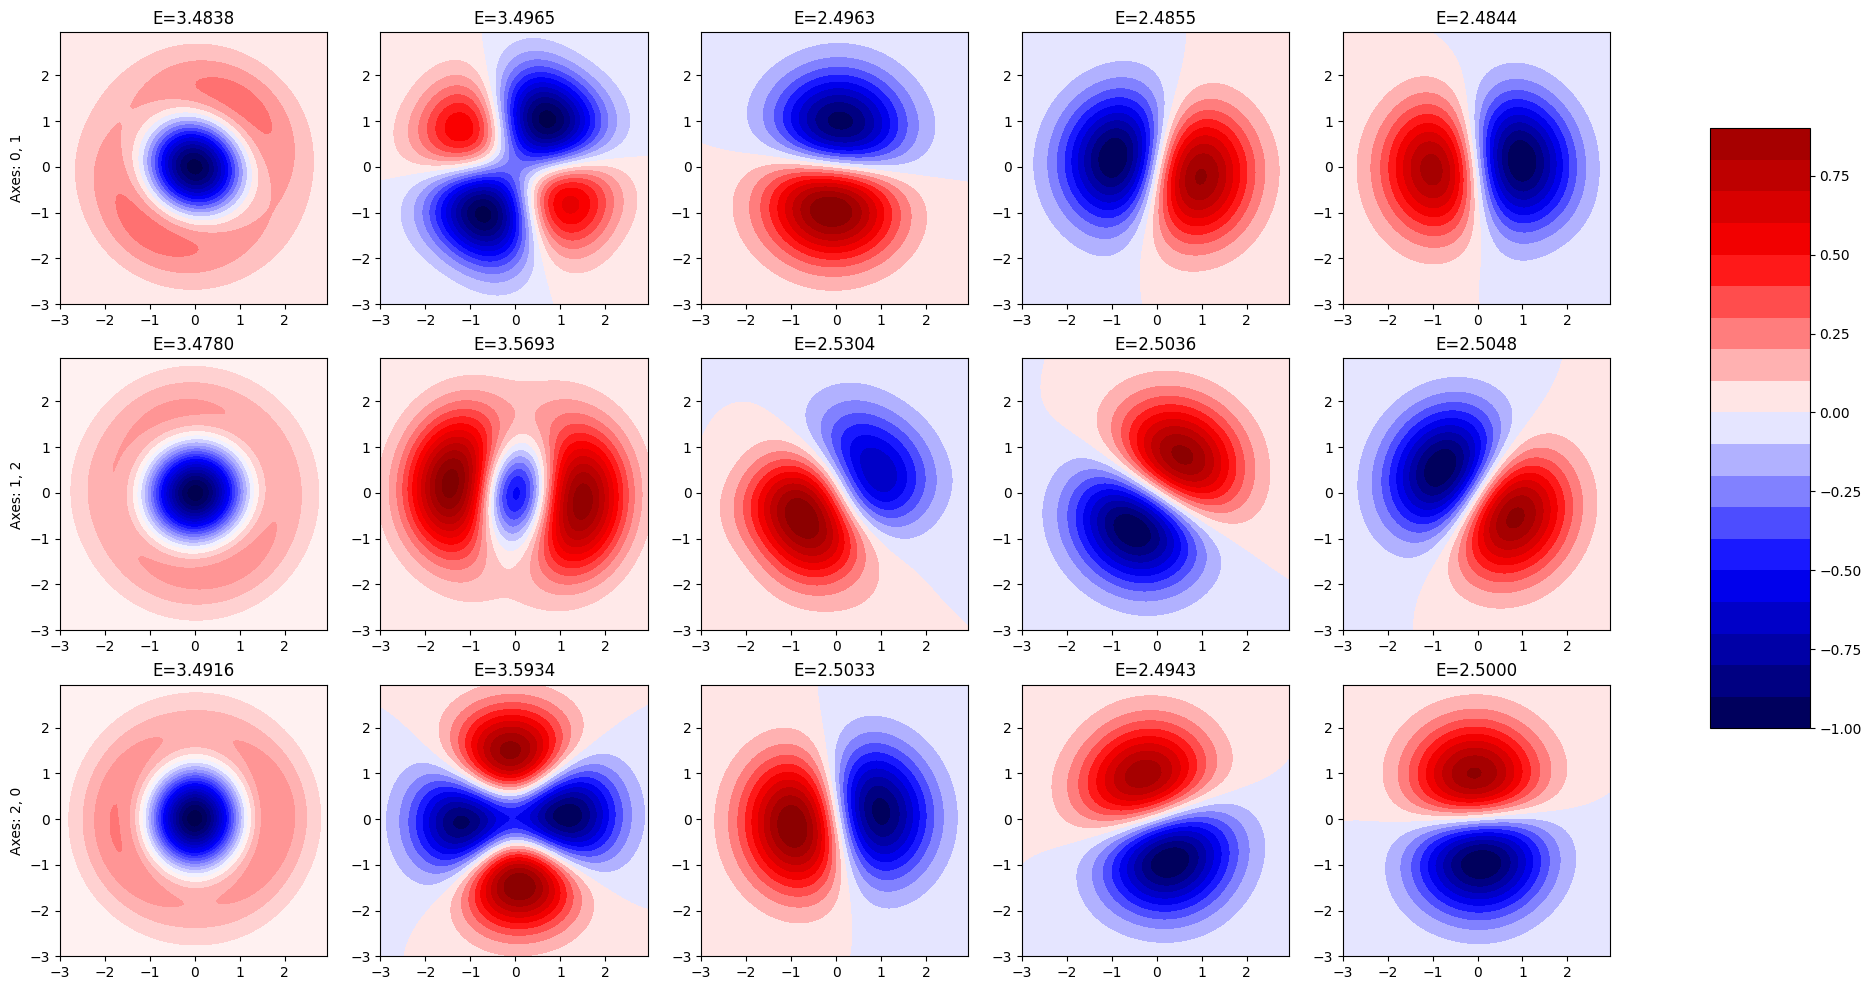

In [50]:
D = 3
fig, axes = plt.subplots(
    D,5,
    figsize=(4*5,D*4),
    squeeze=False
)
for axNumber in range(D):
    print(axNumber)
    grid = torch.zeros(
        (10000,D),
        device="cuda"
    )
    for ix in range(100):
        for iy in range(100):
            grid[ix*100+iy,axNumber%D] = -3 + 6 * ix / 100
            grid[ix*100+iy,(axNumber+1)%D] = -3 + 6 * iy / 100
    e = theTrialFncs.spectrum(grid, False)
    # r2 = [theTrialFncs.squeredResidual(grid)
    wf = theTrialFncs(grid)
    for i in range(5):
        if i != 4:
            pcmesh = axes[axNumber,i].contourf(
            -3 + 6 * np.arange(100) / 100,
            -3 + 6 * np.arange(100) / 100, 
            (wf[:,i] / torch.max(torch.abs(wf[:,i]))).cpu().detach().numpy().reshape(100,100),
            cmap='seismic',
            vmin=-1, vmax=1,
            levels=20
            )
        else:
            axes[axNumber,i].contourf(
            -3 + 6 * np.arange(100) / 100,
            -3 + 6 * np.arange(100) / 100, 
            (wf[:,i] / torch.max(torch.abs(wf[:,i]))).cpu().detach().numpy().reshape(100,100),
            cmap='seismic',
            vmin=-1, vmax=1,
            levels=20
            )
        axes[axNumber,i].set_title(fr'E={e[i]:.4f}') #, $R^2$={r2[i]:.2e}')
    axes[axNumber,0].set_ylabel(f"Axes: {axNumber%D}, {(axNumber+1)%D}")
    # ax.set_title()
    # axes.legend()
    # ax.set_xlim(-3,3)
    # ax.set_ylim(0,None)
    # axes.grid()
# fig.adjust_subplots(hspace=0.2)
cax = plt.axes((0.95, 0.3, 0.05, 0.5))
fig.colorbar(pcmesh, cax=cax, orientation='vertical', ticks=np.arange(-1,1+0.1,0.25))